In [4]:
def __clear_env():
    for key in globals().keys():
        if not key.startswith("__"):# 排除系统内建函数
            globals().pop(key)
__clear_env
import example_pendulum
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
#import torchvision
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import csv
import datetime
from torch.autograd import Variable

In [5]:
environment = "server"
loss_log = []
params = {}
#params['learning_rate'] = trial.suggest_float('lr',0,1)
params['epochs'] = 3000
params['batch_size'] = 500
if environment == 'laptop':
    params['root_dir'] =R'C:\Users\87106\OneDrive\sindy\progress\Angle_t_extractor'
elif environment == 'desktop':
    params['root_dir'] = R'E:\OneDrive\sindy\progress\Angle_t_extractor'
elif environment == 'server':
    params['root_dir'] = R'/mnt/ssd1/stilrmy/Angle_detector/progress/Angle_t_extractor'
params['learning_rate'] = 1e-8

# save parameters
params['if_save'] = True
params['save_date'] = str(datetime.date.today())
params['save_ver'] = '2'
#load parameters
params['if_load'] = True
params['load_date'] = '2023-05-11'
params['load_ver'] = '1'
#noise setting
params['adding_noise'] = False
params['noise_type'] = 'angle_noise'
params['noiselevel'] = 1e-3
#pendulum length setting
params['changing_length'] = True
params['c'] = 1.4e-2
params['g'] = 9.8
params['l'] = 1
PATH = os.path.join(params['root_dir'], params['save_date'],params['save_ver'])
loading_path = os.path.join(params['root_dir'], params['load_date'],params['load_ver'],'model.pth')
print(PATH)

/mnt/ssd1/stilrmy/Angle_detector/progress/Angle_t_extractor/2023-06-25/2


In [6]:
device = 'cuda:0'
data = example_pendulum.get_pendulum_data(10,params)
image = data['x']
image_t = data['dx']
image_tt = data['ddx']
angle = data['z']
angle_t = data['dz']
angle_tt = data['ddz']
print(image.shape)

(5000, 2601)


In [7]:
class angle_predict(nn.Module):
    def __init__(self):
        super(angle_predict, self).__init__()
        self.fc1 = nn.Linear(7803, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 64)
        self.fc6 = nn.Linear(64, 1)
    def forward(self, x):
        m = nn.ReLU()
        x = self.fc1(x)
        x = m(x)
        x = self.fc2(x)
        x = m(x)
        x = self.fc3(x)
        x = m(x)
        x = self.fc4(x)
        x = m(x)
        x = self.fc5(x)
        x = m(x)
        x = self.fc6(x) 
        return x
model = angle_predict()
if params['if_load'] == True:
    model.load_state_dict(torch.load(loading_path))
    print('loading model')
model = model.to(device)

loading model


In [8]:
opt = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
for epoch in range(params['epochs']):
    loss_sum = 0
    loss_angle_sum = 0
    loss_angle_t_sum = 0
    loss_angle_tt_sum = 0
    count = 0 
    model.train()
    for i in range(len(data['z'])//params['batch_size']):
        image_temp = image[i*params['batch_size']:(i+1)*params['batch_size'],:]
        angle_t_temp = angle_t[i*params['batch_size']:(i+1)*params['batch_size']]
        for j in range(image_temp.shape[0]-2):
            input = torch.tensor(image_temp[j:j+3,:],dtype=torch.float32).to(device)
            input = input.view(-1)
            input = Variable(input)
            pre = model.forward(input)
            angle_t_true = torch.tensor(angle_t_temp[j],dtype=torch.float32).to(device)
            loss_angle_t = torch.abs(angle_t_true - pre)
            loss = loss_angle_t
            loss_sum += loss
            count += 1
            opt.zero_grad()
            loss.backward()
            opt.step()
        model.eval()
    loss_log.append(loss_sum.item()/count)
    print('epoch: ', epoch+1, 'loss: ', loss_sum.item()/count,)

epoch:  1 loss:  0.22608713663246738
epoch:  2 loss:  0.20278718634302836
epoch:  3 loss:  0.18394028996846762
epoch:  4 loss:  0.1707366943359375
epoch:  5 loss:  0.16282444230045182
epoch:  6 loss:  0.15896230184409513
epoch:  7 loss:  0.15595647972750376
epoch:  8 loss:  0.15328214714326055
epoch:  9 loss:  0.15092315061025352
epoch:  10 loss:  0.14846724544663026
epoch:  11 loss:  0.1463233304310994
epoch:  12 loss:  0.14435147817833835
epoch:  13 loss:  0.14238967589106424
epoch:  14 loss:  0.14043744558311372
epoch:  15 loss:  0.13883727046859312
epoch:  16 loss:  0.13720569533995355
epoch:  17 loss:  0.13578985129973017
epoch:  18 loss:  0.13446742291431352
epoch:  19 loss:  0.13289342673428087
epoch:  20 loss:  0.13125813802083333
epoch:  21 loss:  0.1301400303361885
epoch:  22 loss:  0.12893817702450427
epoch:  23 loss:  0.12745215481064884
epoch:  24 loss:  0.12634584970742344
epoch:  25 loss:  0.12569397462898468
epoch:  26 loss:  0.12436077317080824
epoch:  27 loss:  0.1231

KeyboardInterrupt: 

In [9]:
def saving(model,PATH):
    if os.path.exists(PATH) == False:
        os.makedirs(PATH)
    model_PATH = os.path.join(PATH, 'model.pth')
    torch.save(model.state_dict(), model_PATH)
    params_PATH = os.path.join(PATH, 'params.txt')
    with open(params_PATH, 'w') as f:
        f.write(str(params))
        f.close()
    loss_PATH = os.path.join(PATH, 'loss_log.csv')
    with open(loss_PATH, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(loss_log)
    #fig_PATH = os.path.join(PATH, 'loss.png') 
    #plt.savefig(fig_PATH)
    print("data saved")
    return

In [10]:
if params['if_save'] == True:
    saving(model,PATH)

data saved


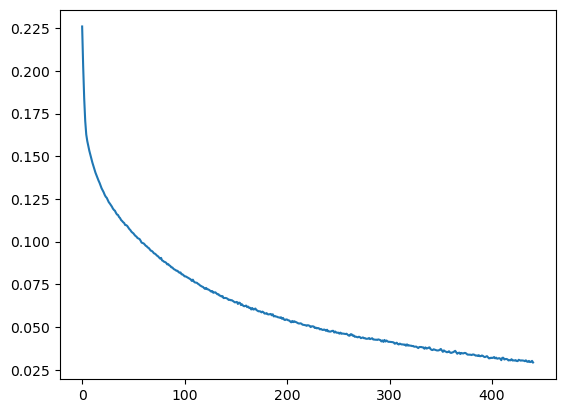

In [11]:
#plotting result
plt.plot(loss_log)
fig_PATH = os.path.join(PATH, 'loss.png') 
plt.savefig(fig_PATH, bbox_inches='tight', pad_inches = +0.1)
plt.show()